#Colab Setup


In [1]:
!apt-get install -y libtiff5-dev &

!pip install Pillow==4.1.1
!pip install --force-reinstall scipy
!pip install --force-reinstall pandas
!pip install prompt-toolkit==1.0.15


!pip install fastai==0.7.0 
!pip install torchtext==0.2.3

!pip install kaggle --upgrade

libsm6 is already the newest version (2:1.2.2-1).
libxext6 is already the newest version (2:1.3.3-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
accelerator: cu80


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtiff5-dev is already the newest version (4.0.8-5ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
  Using cached https://files.pythonhosted.org/packages/a8/0b/f163da98d3a01b3e0ef1cab8dd2123c34aee2bafbb1c5bffa354cc8a1730/scipy-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/88/29/f4c845648ed23264e986cdc5fbab5f8eace1be5e62144ef69ccc7189461d/numpy-1.15.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: numpy 1.15.0
    Uninstalling numpy-1.15.0:
      Successfully uninstalled numpy-1.15.0
  Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0
Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.4.2)


# Dogs breeds

https://youtu.be/JNxcznsrRb8?t=1h31m8s

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
torch.cuda.set_device(0)

Kaggle Dog Breed Identification. Get data from https://www.kaggle.com/c/dog-breed-identification

In [35]:
!mkdir -p ~/.kaggle/
!echo '{"username":"cesaremontresor","key":"80ee3d90f3428ce0830665ee189a10d7"}' > ~/.kaggle/kaggle.json
!cat ~/.kaggle/kaggle.json

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dog-breed-identification -f labels.csv.zip -p ~/data/dogbreed/
!kaggle competitions download -c dog-breed-identification -f train.zip -p ~/data/dogbreed/
!kaggle competitions download -c dog-breed-identification -f test.zip -p ~/data/dogbreed/

!cd ~/data/dogbreed; unzip -oq labels.csv.zip
!cd ~/data/dogbreed; unzip -oq train.zip
!cd ~/data/dogbreed; unzip -oq test.zip

{"username":"cesaremontresor","key":"80ee3d90f3428ce0830665ee189a10d7"}
labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
PATH = "data/dogbreed/"
sz = 224
arch = resnext101_64
bs = 58

In [0]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [38]:
n

10222

In [39]:
len(val_idxs)

2044

In [40]:
# If you haven't downloaded weights.tgz yet, download the file.
#     http://forums.fast.ai/t/error-when-trying-to-use-resnext50/7555
#     http://forums.fast.ai/t/lesson-2-in-class-discussion/7452/222
!mkdir -p /usr/local/lib/python3.6/dist-packages/fastai/weights/
!cd /usr/local/lib/python3.6/dist-packages/fastai/; wget -O weights.tgz http://files.fast.ai/models/weights.tgz

!cd /usr/local/lib/python3.6/dist-packages/fastai/; tar xvfz weights.tgz 

--2018-07-26 18:56:21--  http://files.fast.ai/models/weights.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1195411318 (1.1G) [text/plain]
Saving to: ‘weights.tgz’

weights.tgz         100%[===================>]   1.11G   111MB/s    in 10s     

2018-07-26 18:56:32 (110 MB/s) - ‘weights.tgz’ saved [1195411318/1195411318]

weights/
weights/wrn_50_2f.pth
weights/resnext_101_32x4d.pth
weights/resnext_101_64x4d.pth
weights/inceptionresnetv2-d579a627.pth
weights/inceptionv4-97ef9c30.pth
weights/resnext_50_32x4d.pth


## Initial exploration

In [41]:
!ls {PATH}

labels.csv  labels.csv.zip  test  test.zip  tmp  train	train.zip


In [0]:
label_df = pd.read_csv(label_csv)

In [43]:
blacklist = [
    '556e0c4e43195062a10255a27af53b67',
]
print('Original:', len(label_df))
label_df = label_df[~label_df['id'].isin(blacklist)]
print('Filtered:', len(label_df))

Original: 10222
Filtered: 10221


In [44]:
label_df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [45]:
label_df.pivot_table(index="breed", aggfunc=len).sort_values('id', ascending=False)

id
breed                              
scottish_deerhound              126
maltese_dog                     117
afghan_hound                    116
entlebucher                     115
bernese_mountain_dog            114
shih-tzu                        112
great_pyrenees                  111
pomeranian                      111
basenji                         110
samoyed                         109
airedale                        107
tibetan_terrier                 107
leonberg                        106
cairn                           106
beagle                          105
japanese_spaniel                105
australian_terrier              102
blenheim_spaniel                102
miniature_pinscher              102
irish_wolfhound                 101
lakeland_terrier                 99
saluki                           99
papillon                         96
whippet                          95
siberian_husky                   95
norwegian_elkhound               95
pug                              94
chow                             93
italian_greyhound                92
pembroke                         92
...                             ...
german_short-haired_pointer      75
boxer                            75
bull_mastiff                     75
borzoi                           75
pekinese                         75
cocker_spaniel                   74
american_staffordshire_terrier   74
doberman                         74
brittany_spaniel                 73
malinois                         73
standard_schnauzer               72
flat-coated_retriever            72
border_collie                    72
curly-coated_retriever           72
kuvasz                           71
chihuahua                        71
soft-coated_wheaten_terrier      71
redbone                          71
french_bulldog                   70
vizsla                           70
german_shepherd                  69
tibetan_mastiff                  69
otterhound                       69
giant_schnauzer                  69
walker_hound                     69
golden_retriever                 67
brabancon_griffon                67
komondor                         67
briard                           66
eskimo_dog                       66

[120 rows x 1 columns]

In [0]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [47]:
fn = PATH + data.trn_ds.fnames[0]; fn

'data/dogbreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

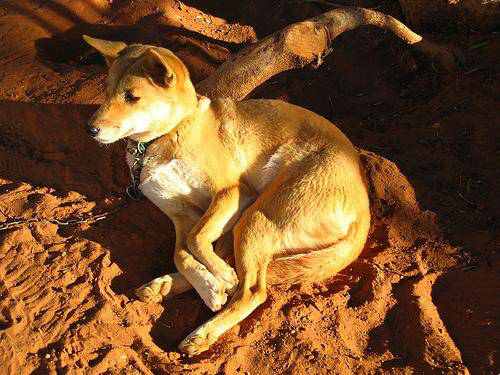

In [48]:
img = PIL.Image.open(fn); img

In [49]:
img.size

(500, 375)

In [0]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [0]:
row_sz, col_sz = list(zip(*size_d.values()))

In [0]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [53]:
row_sz[:5]

array([500, 500, 500, 500, 500])

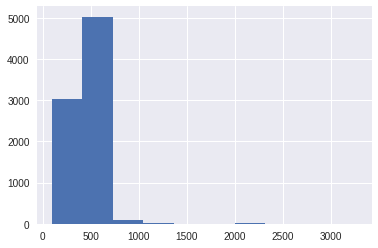

In [54]:
plt.hist(row_sz);

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

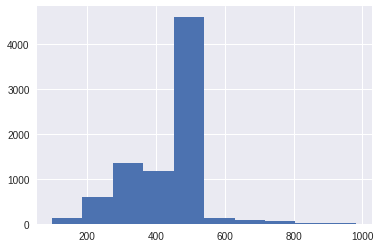

In [55]:
plt.hist(row_sz[row_sz < 1000])

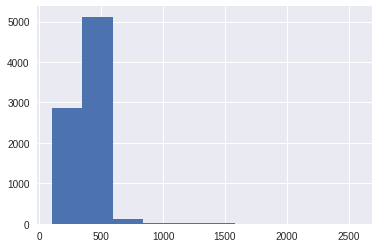

In [56]:
plt.hist(col_sz);

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

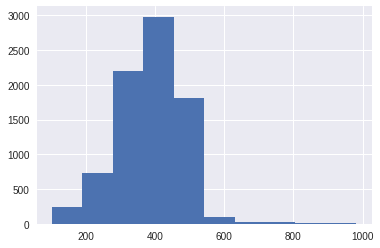

In [57]:
plt.hist(col_sz[col_sz < 1000])

In [58]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [59]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

## Initial model

In [0]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tmfs = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

### Precompute

In [61]:
data = get_data(sz, bs)

In [62]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 179/179 [05:50<00:00,  1.96s/it]


In [63]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy   
    0      0.957703   0.393022   0.899706  
    1      0.445319   0.313753   0.904599  
    2      0.300112   0.268149   0.918787  
 77%|███████▋  | 109/141 [00:03<00:00, 34.69it/s, loss=0.225]

    3      0.222564   0.255055   0.919276  
    4      0.1877     0.253582   0.922211  



[array([0.25358]), 0.9222113516932597]

### Augment

In [0]:
from sklearn import metrics

In [65]:
data = get_data(sz, bs)

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [67]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy   
    0      1.189235   0.453894   0.896282  
    1      0.557468   0.319164   0.912427  



[array([0.31916]), 0.912426615706162]

In [0]:
learn.precompute = False

In [0]:
learn.fit(1e-2, 5, cycle_len=1)

In [0]:
learn.save('224_pre')

In [0]:
learn.load('224_pre')

## Increase size

In [0]:
# Starting training on small images for a few epochs, then switching to bigger images, and continuing training is an amazingly effective way to avoid overfitting.

# http://forums.fast.ai/t/planet-classification-challenge/7824/96
# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(299, bs)) 
learn.freeze()

#Source:   
#    def set_data(self, data, precompute=False):
#        super().set_data(data)
#        if precompute:
#            self.unfreeze()
#            self.save_fc1()
#            self.freeze()
#            self.precompute = True
#        else:
#            self.freeze()
#File:      ~/fastai/courses/dl1/fastai/conv_learner.py

In [0]:
learn.summary()

In [0]:
learn.fit(1e-2, 3, cycle_len=1)

Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.

In [0]:
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

Training loss and validation loss are getting closer and smaller. We are on right track.

In [0]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

In [0]:
len(data.val_ds.y), data.val_ds.y[:5]

In [0]:
learn.save('299_pre')

In [0]:
learn.load('299_pre')

In [0]:
learn.fit(1e-2, 1, cycle_len=2) # 1+1 = 2 epochs

In [0]:
learn.save('299_pre')

In [0]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

This dataset is so similar to ImageNet dataset. Training convolution layers doesn't help much. We are not going to unfreeze.

## Create submission

https://youtu.be/9C06ZPF8Uuc?t=1905

In [0]:
data.classes

In [0]:
data.test_ds.fnames

In [0]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)
#accuracy_np(probs, y), metrcs.log_loss(y, probs) # This does not make sense since test dataset has no labels

In [0]:
probs.shape # (n_images, n_classes)

In [0]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [0]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [0]:
df.head()

In [0]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [0]:
FileLink(f'{SUBM}subm.gz')

## Individual prediction

In [0]:
fn = data.val_ds.fnames[0]
fn

In [0]:
Image.open(PATH + fn).resize((150, 150))

In [0]:
# Method 1.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

In [0]:
learn.data.classes[np.argmax(preds)]

In [0]:
# Method 2.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(open_image(PATH + fn)) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])
np.argmax(preds)